<a href="https://colab.research.google.com/github/apchavezr/16.-Aprendizaje-Profundo-para-Ciencia-de-Datos/blob/main/Transfer_Learning_VGG16_TF_Flowers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ejemplo práctico: Transfer learning con VGG16 para clasificación de imágenes

Este cuaderno ilustra cómo utilizar **transfer learning** con el modelo preentrenado **VGG16** para una tarea de clasificación de imágenes con pocas muestras, utilizando como conjunto de datos un subconjunto de **flowers** de `tensorflow_datasets`.

El objetivo es demostrar cómo reutilizar las capas convolucionales de un modelo entrenado en **ImageNet** y adaptar solo la parte final del modelo a una nueva tarea con recursos limitados.


In [1]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np


In [5]:
import tensorflow_datasets as tfds

(ds_train, ds_val), ds_info = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:]'],
    as_supervised=True,
    with_info=True
)

IMG_SIZE = (96, 96)
BATCH_SIZE = 32

def format_example(image, label):
    image = tf.image.resize(image, IMG_SIZE)
    image = image / 255.0
    return image, label

train = ds_train.map(format_example).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val = ds_val.map(format_example).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


In [6]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(96, 96, 3))
# Descongelar algunas capas para realizar ajustes finos
for layer in base_model.layers[-1:]:  # Descongele la última 1 capas de VGG16
    layer.trainable = True

x = base_model.output
x = Flatten()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(ds_info.features['label'].num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Compilar el modelo con una tasa de aprendizaje más baja para realizar ajustes finos
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 96, 96, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 96, 96, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 48, 48, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 48, 48, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 24, 24, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 24, 24, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 12, 12, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,305,285 (58.39 MB)

 Trainable params: 15,305,285 (58.39 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
history = model.fit(train, validation_data=val, epochs=2)


Epoch 1/2
92/92 ━━━━━━━━━━━━━━━━━━━━ 1338s 14s/step - accuracy: 0.3328 - loss: 1.5789 - val_accuracy: 0.6703 - val_loss: 0.8600
Epoch 2/2
92/92 ━━━━━━━━━━━━━━━━━━━━ 1322s 14s/step - accuracy: 0.6523 - loss: 0.9134 - val_accuracy: 0.7820 - val_loss: 0.5850


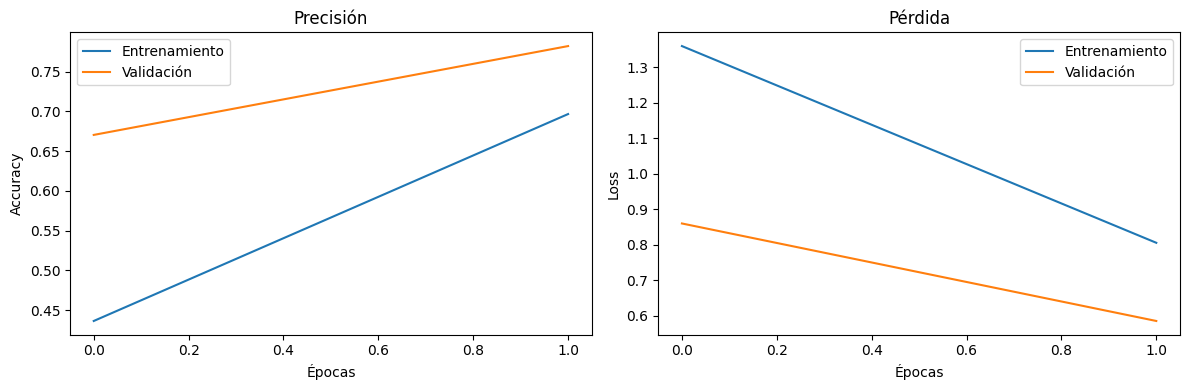

In [8]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.title('Precisión')
plt.xlabel('Épocas')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title('Pérdida')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


**Conclusiones**

1. **Reducción de costos computacionales y de datos**

  El ejercicio demuestra que es posible entrenar un modelo de clasificación de imágenes con una cantidad limitada de datos y en pocas épocas, gracias al uso de VGG16 como extractor de características. Esto es especialmente relevante en contextos donde el etiquetado manual es costoso, como ocurre frecuentemente en sectores públicos y en investigación aplicada.

1. **Reutilización efectiva del conocimiento visual**
    
  Las capas convolucionales de VGG16, preentrenadas sobre el conjunto ImageNet, permiten capturar características visuales genéricas como bordes, colores, formas y texturas. Estas representaciones son reutilizadas exitosamente en una nueva tarea de clasificación de flores, lo cual valida el principio del aprendizaje por transferencia.

1. **Entrenamiento estable y convergente**

  El comportamiento de las curvas de entrenamiento (precisión y pérdida) sugiere que el modelo logra convergencia rápida en unas pocas épocas, sin señales evidentes de sobreajuste. Esto se debe, en parte, a que solo se entrena la parte final del modelo (capa densa), manteniendo congeladas las capas convolucionales.

1. **Transfer learning como herramienta accesible y modular**

  La implementación práctica con TensorFlow y tensorflow_datasets muestra que el transfer learning puede aplicarse de manera accesible, con pocas líneas de código, sin necesidad de infraestructura avanzada. Esto abre oportunidades pedagógicas para su uso en cursos de grado y posgrado.

1. **Generalización del enfoque a contextos locales**

  Aunque se utilizó un conjunto de datos genérico (flores), la misma técnica puede extenderse a tareas locales como:

* Clasificación de infraestructura urbana (parques, techos, avenidas).

* Identificación de cultivos desde imágenes satelitales en Colombia.

* Detección de residuos o minería ilegal en áreas naturales protegidas.